# Scraping and processing rain data
This notebook scraps Meteosuisse rainfall data from a third-party website holding a database. Written by Eliott Guenat in 2020

In [6]:
from lxml import html
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 22})

## Scraping the data

In [2]:
df = pd.DataFrame()

In [ ]:
DayMth = np.array([[1, 31],[2,28],[3,31],[4,30],[5,31],[6,30],[7,31],[8,31],[9,30],[10,31],[11,30],[12,31]])
Data = np.zeros((1,7300))            

for year in np.arange(2000,2020):
    cnt = 0
    for month in np.arange(1,13):
        StrMth = str(month)
        if month < 10:
            StrMth = '0'+StrMth
    
        for day in np.arange(1,DayMth[month-1,1]+1):
                   StrDay = str(day)
                   if day < 10:
                       StrDay = '0'+StrDay  
                   page = requests.get('https://www.prevision-meteo.ch/climat/horaire/geneve-cointrin/'+str(year)+'-'+StrMth+'-'+StrDay)
                   tree = html.fromstring(page.content)
                   a = str(html.tostring(tree))
                   b1 = a[a.find('Precipitations totale'):-1]
                   b2 = b1[b1.find('min</td>')+6:-1]
                   b3 = b2[b2.find(';">')+3:b2.find(';">')+8]
                   if '<' in b3:
                       b3 = b3[0:b3.find('<')]
                   Data = float(b3)
                   s1 = pd.Series({'Year' : int(year),
                                   'Month' : int(month),
                                   'Day' : int(day),
                                   'Precipitation' : Data})
                   df = df.append([s1])


        print(str(year)+'-'+StrMth)

In [ ]:
df.to_csv(r'PrecipitationGVA_daily.csv', index = False)

## Processing the data

In [3]:
df = pd.read_csv('PrecipitationGVA_daily.csv')

### flow duration curve for each year  

In [4]:
df1 = pd.DataFrame(index=np.arange(1,353))
for yr in np.arange(2000,2015):
    df1[yr]=df[df['Year']==yr].sort_values(by='Precipitation',ascending=False)['Precipitation'].reset_index().drop(['index'],axis=1)
df1['Min'] = df1.agg("min", axis="columns")
df1['Max'] = df1.agg("max", axis="columns")
df1['Median'] = df1.agg("median", axis="columns")
df1.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,Min,Max,Median
1,41.0,50.0,41.2,27.0,47.0,27.0,67.0,43.0,53.0,29.0,33.0,26.4,32.8,41.6,32.8,26.4,67.0,41.0
2,37.0,35.0,37.0,26.0,43.0,24.0,56.0,38.0,50.0,29.0,26.0,25.1,30.7,35.0,32.3,24.0,56.0,35.0
3,30.0,35.0,34.0,25.0,34.0,24.0,34.0,34.0,50.0,28.0,26.0,18.6,27.8,28.2,28.0,18.6,50.0,28.2
4,30.0,31.0,33.0,23.0,32.0,24.0,30.0,32.0,37.0,27.0,24.0,18.1,24.2,24.4,27.6,18.1,37.0,27.6
5,27.0,31.0,31.0,22.0,32.0,23.0,29.0,29.0,33.0,26.0,20.0,17.9,23.4,24.2,25.1,17.9,33.0,26.0


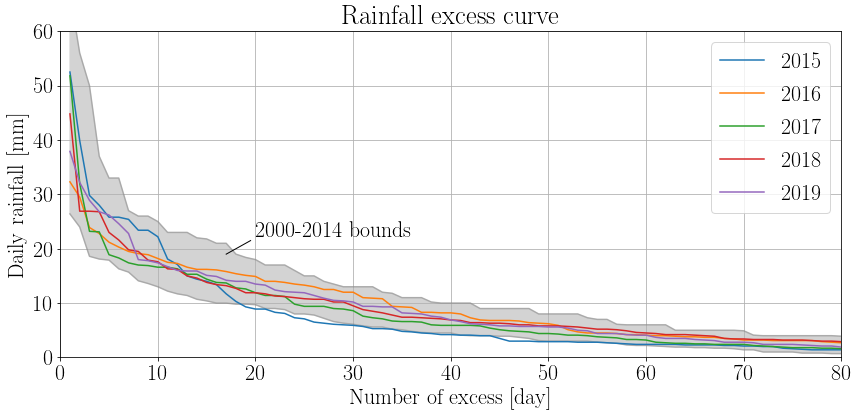

In [7]:
plt.figure(figsize=(14,6))

plt.plot(df1['Min'],color='grey',alpha=0.5)
plt.plot(df1['Max'],color='grey',alpha=0.5)
#plt.plot(df1['Median'],color='k',alpha=0.8)
plt.fill_between(df1['Min'].index,df1['Min'], df1['Max'],color='lightgrey')


for yr in np.arange(2015,2020):
    plt.plot(np.arange(1,354),df[(df['Year']==yr)].sort_values(by='Precipitation',ascending=False)['Precipitation'],label=yr)

plt.legend()
plt.xlabel('Number of excess [day]')
plt.ylabel('Daily rainfall [mm]')
plt.title('Rainfall excess curve')
plt.text(20,22,'2000-2014 bounds')
plt.grid(True)
plt.plot(np.array([19.5,17]),np.array([21.5,19]),'-k',linewidth=1)
plt.ylim([0,60])
plt.xlim([0,80])
plt.show()

### Yearly number of dry days

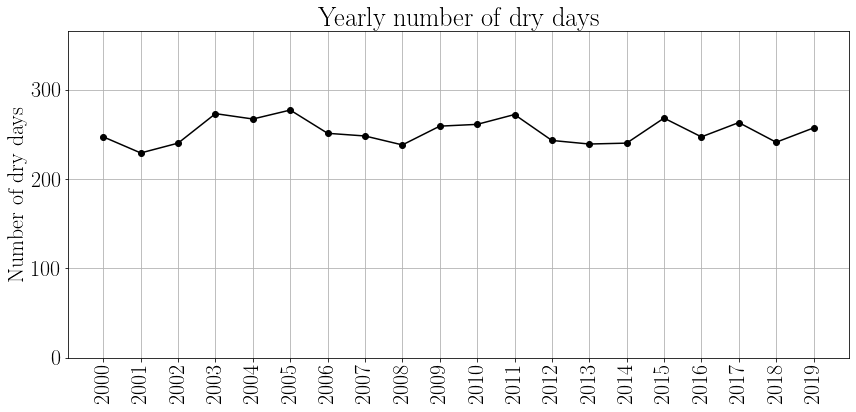

In [10]:
DaysNoRain = pd.Series()
for yr in df['Year'].unique():
    DaysNoRain = DaysNoRain.append(pd.Series({yr : len(df[(df['Year']==yr) & (df['Precipitation']<1)])}),ignore_index=False)

plt.figure(figsize=(14,6))
plt.plot(DaysNoRain,'-ko')
plt.ylabel('Number of dry days')
plt.grid('True')
plt.xticks(np.arange(2000, 2020, 1),rotation='vertical')
plt.title('Yearly number of dry days')
plt.ylim([0,365])
plt.show()

### Identification of dry periods and their duration (number of consecutive dry days)

In [13]:
dryPeriod = np.array([])
cnt = 0
dfDry0 = pd.DataFrame()
for yr in df['Year'].unique():
    a = df[df['Year']==yr]['Precipitation']
    for d in np.arange(0,len(a)):
        if a.iloc[d]<0+0.0001:
            cnt += 1
        if (a.iloc[d]>0+0.0001) & (cnt>0):
            dryPeriod = np.append(dryPeriod,cnt)
            dfDry0 = dfDry0.append(pd.DataFrame([{'Year' : yr,'Dry Days': cnt, 
                                               }],index=[1]))
            cnt = 0
            
dfDry02 = pd.DataFrame()
for yr in df['Year'].unique():
    a = df[df['Year']==yr]['Precipitation']
    for d in np.arange(0,len(a)):
        if a.iloc[d]<0.2+0.0001:
            cnt += 1
        if (a.iloc[d]>0.2+0.0001) & (cnt>0):
            dryPeriod = np.append(dryPeriod,cnt)
            dfDry02 = dfDry02.append(pd.DataFrame([{'Year' : yr,'Dry Days': cnt, 
                                               }],index=[1]))
            cnt = 0

dfDry05 = pd.DataFrame()
for yr in df['Year'].unique():
    a = df[df['Year']==yr]['Precipitation']
    for d in np.arange(0,len(a)):
        if a.iloc[d]<0.5+0.0001:
            cnt += 1
        if (a.iloc[d]>0.5+0.0001) & (cnt>0):
            dryPeriod = np.append(dryPeriod,cnt)
            dfDry05 = dfDry05.append(pd.DataFrame([{'Year' : yr,'Dry Days': cnt, 
                                               }],index=[1]))
            cnt = 0
            
dfDry1 = pd.DataFrame()
for yr in df['Year'].unique():
    a = df[df['Year']==yr]['Precipitation']
    for d in np.arange(0,len(a)):
        if a.iloc[d]<1+0.0001:
            cnt += 1
        if (a.iloc[d]>1+0.0001) & (cnt>0):
            dryPeriod = np.append(dryPeriod,cnt)
            dfDry1 = dfDry1.append(pd.DataFrame([{'Year' : yr,'Dry Days': cnt, 
                                               }],index=[1]))
            cnt = 0
            


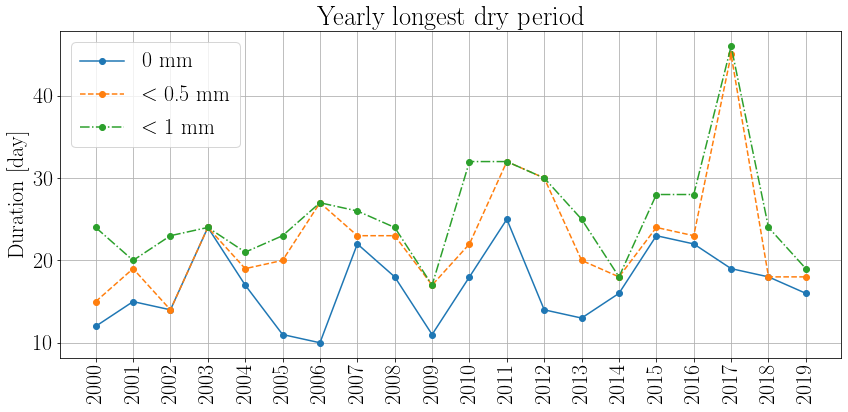

In [61]:
#Yearly longest dry period
plt.figure(figsize=(14,6))
line1, = plt.plot(dfDry0.groupby('Year').max(),'o-',label='0 mm')
line2, = plt.plot(dfDry05.groupby('Year').max(),'o--',label='$<$ 0.5 mm')
line4, = plt.plot(dfDry1.groupby('Year').max(),'o-.',label='$<$ 1 mm')
plt.grid('True')
plt.xticks(np.arange(2000,2020,1),rotation='vertical')
plt.ylabel('Duration [day]')
plt.title('Yearly longest dry period')
plt.legend()
plt.show()